In [0]:
# !pip install ucimlrepo
# !pip install --upgrade pip
# !pip install missingno
# !pip install sweetviz
# !pip install MLflow 
# !pip install pytest
# !pip install imblearn


# LIBRERIAS

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
import missingno as msno
import sweetviz as sv

# Librerías de ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.tree import export_text
from sklearn.tree import plot_tree


# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Manejo de desequilibrio de clases
from imblearn.over_sampling import SMOTE

# MLflow para el seguimiento de experimentos
import mlflow
import mlflow.sklearn

# IMPORTAR DATA

In [0]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names = [
    "CLASS", "ALCOHOL", "MALICACID", "ASH", "ALCALINITY_OF_ASH",
    "MAGNESIUM", "TOTAL_PHENOLS", "FLAVANOIDS", "NONFLAVANOID_PHENOLS",
    "PROANTHOCYANINS", "COLOR_INTENSITY", "HUE",
    "DILUTED_WINES", "PROLINE"
] # por simplicidad cambiamos OD280_OD315_OF_DILUTED_WINES a DILUTED_WINES

df = pd.read_csv(url, header=None, names=column_names)

In [0]:
df.head()

,CLASS,ALCOHOL,MALICACID,ASH,ALCALINITY_OF_ASH,MAGNESIUM,TOTAL_PHENOLS,FLAVANOIDS,NONFLAVANOID_PHENOLS,PROANTHOCYANINS,COLOR_INTENSITY,HUE,DILUTED_WINES,PROLINE
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# DATOS FALTANTES

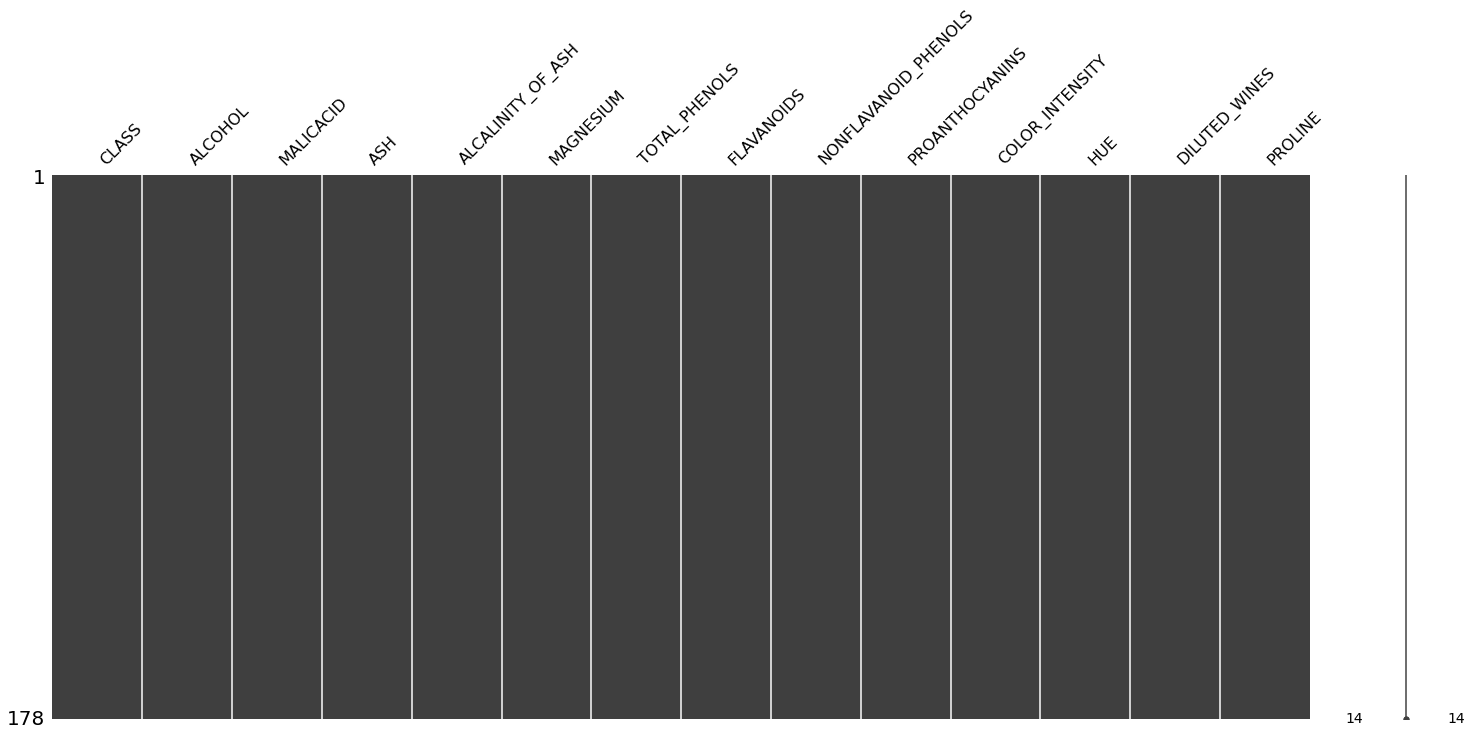

In [0]:
msno.matrix(df)
plt.show()

# EDA PRELIMINAR

In [0]:
report = sv.analyze(df)
report.show_html("sweetviz_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


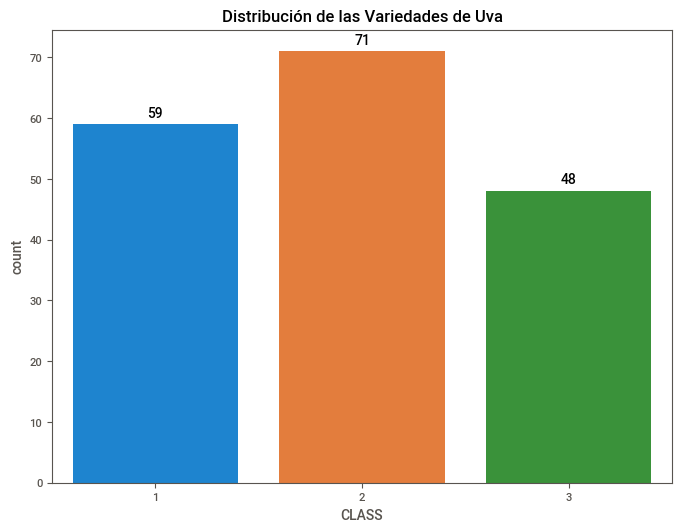

In [0]:
# Gráfico de conteo con etiquetas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CLASS', data=df)
plt.title('Distribución de las Variedades de Uva')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

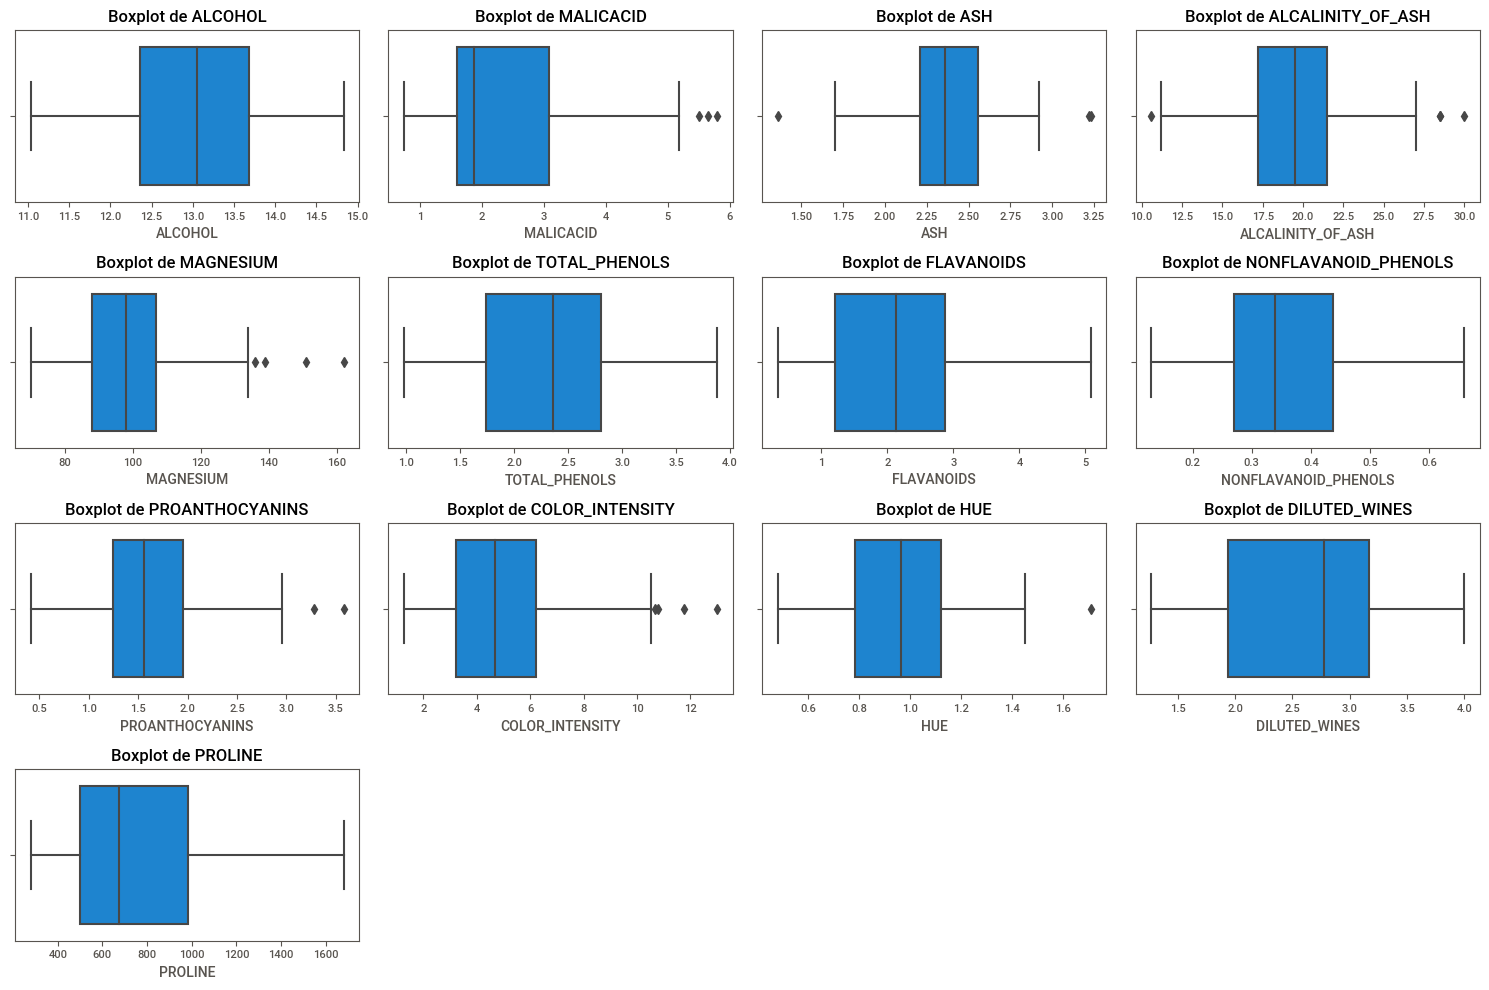

In [0]:
plt.figure(figsize=(15, 10))

# Generar un boxplot para cada columna numérica
for i, col in enumerate(column_names[1:]):  # Excluimos 'CLASS' porque es la variable objetivo
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()

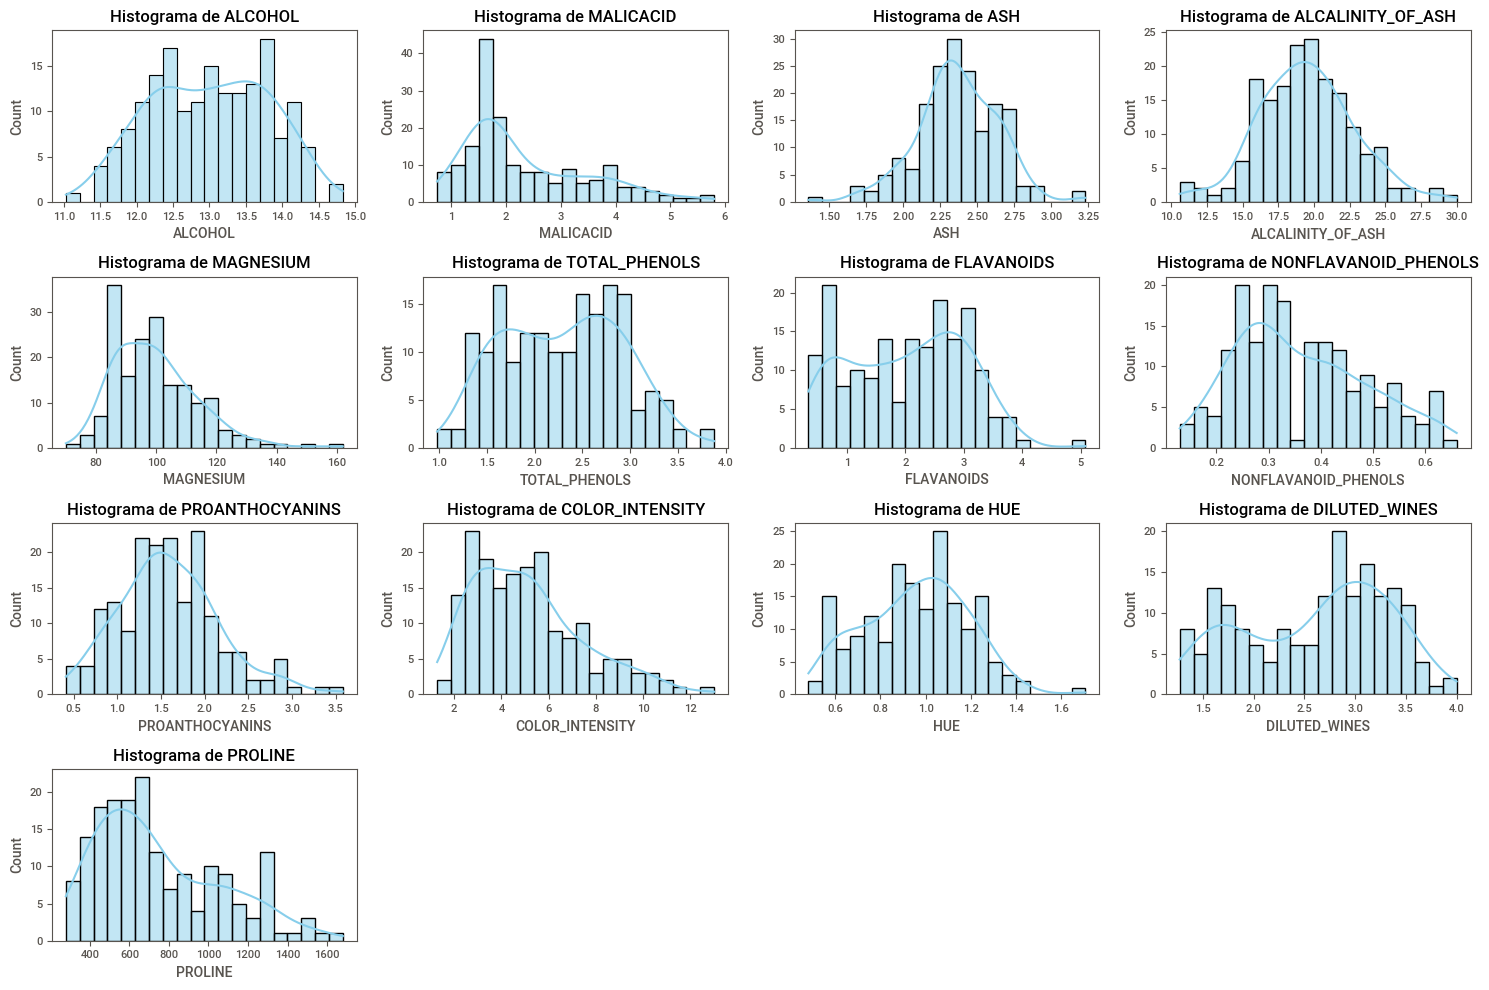

In [0]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(column_names[1:]):  # Excluimos 'CLASS' porque es la variable objetivo
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.tight_layout()

plt.show()

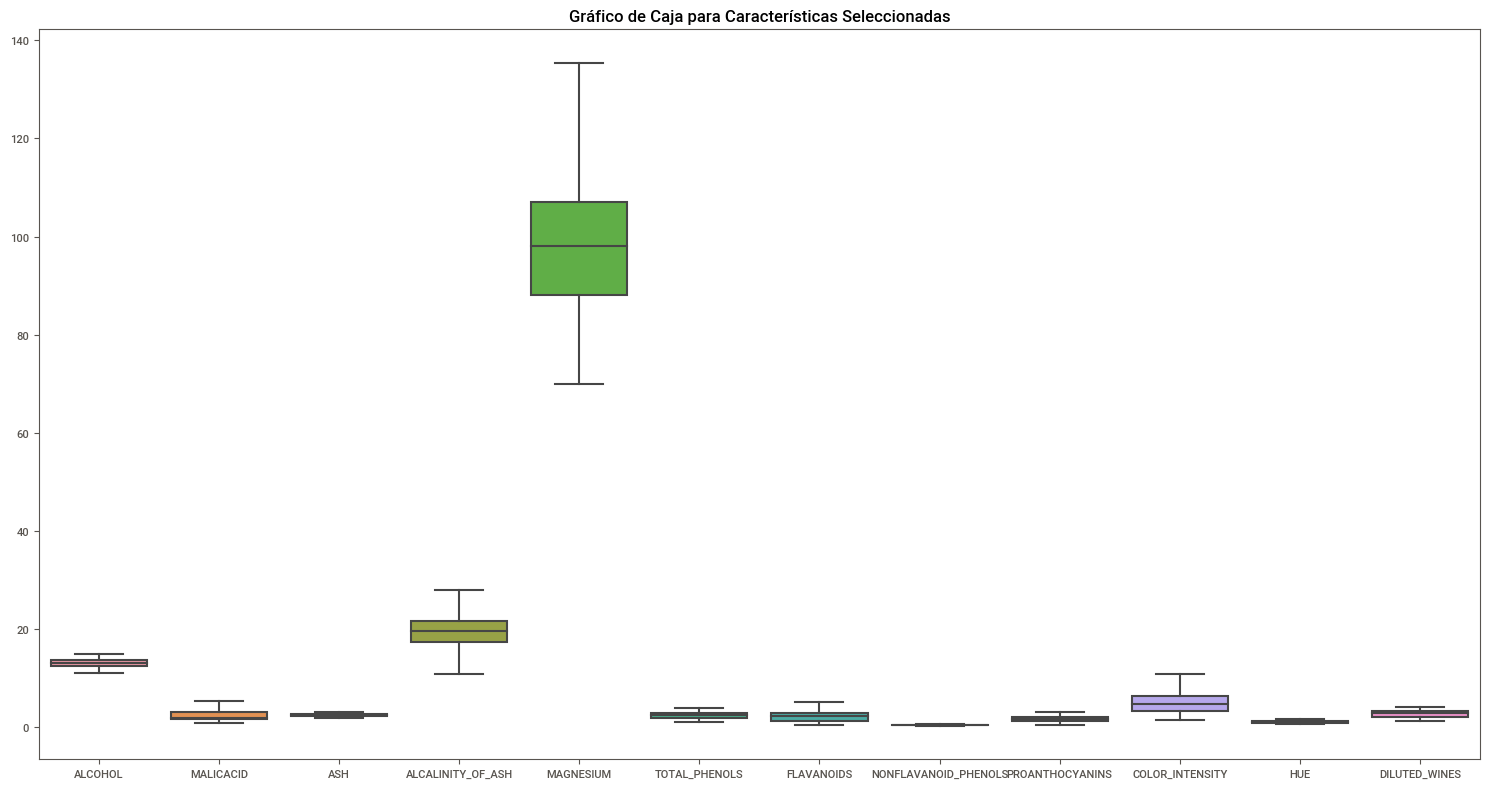

In [0]:
# Gráfico de caja excluyendo CLASS y PROLINE
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.iloc[:, 1:-1])  #sin PROLINE ya que el rango es distinto
plt.title("Gráfico de Caja para Características Seleccionadas")
plt.tight_layout()
plt.show()

### estos graficos como los boxplot o diagramas de bigotes inicialmente nos ayudan a visualizar cuales de las distintas variables de nuestro conjunto de datos muestra algunas muestras atipicas como en los casos de MALICACID, ASH, ALCALINITY_OF_ASH, MAGNESIUM, PROANTHOCYANINS, COLOR_INTENSITY, donde en su mayoria hay datos aislado por encima del cuartil 3, adicionalmente con los histogramas podemos comprender si es que algunas caracteristicas presentan distribuciones bimodales o multimodales, como son el caso de TOTAL_PHENOLS, DILUTED_WINES, esto nos puede sugerir iniciar un análisis de asimetría y curtosispara validar que efectivamente nuestro modelo podría mejorar intentando separar los dos o más grupos internos 



# Manejo de valores extremos

In [0]:
def recortar_outliers(df, columnas):
    '''
    recortaremos los valores atípicos por su limite_inferior o limite_inferior correspondientemente
    '''
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
        df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])
    return df
columnas_numericas = column_names[1:] 
df_RIQ1 = recortar_outliers(df, columnas_numericas)

In [0]:
def eliminar_outliers(df, columnas):
    '''
    eliminaremos los valores extremos menores o mayoers a limite_inferior o limite_inferior correspondientemente
    '''
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]
        
    return df

df_RIQ2 = eliminar_outliers(df, columnas_numericas)

In [0]:
def reemplazar_outliers(df, columnas):
    '''
    recortaremos los valores atípicos por Q1 o Q3 correspondientemente al más cercano
    '''
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Reemplazar los valores fuera de los límites
        df[col] = np.where(df[col] < limite_inferior, Q1, df[col])
        df[col] = np.where(df[col] > limite_superior, Q3, df[col])
        
    return df

# Aplicar a las columnas numéricas
df_RIQ3 = reemplazar_outliers(df, columnas_numericas)

### Boxplots sin valores atipicos utilizando el método de recortar_outliers ya que no es tan agresivo:

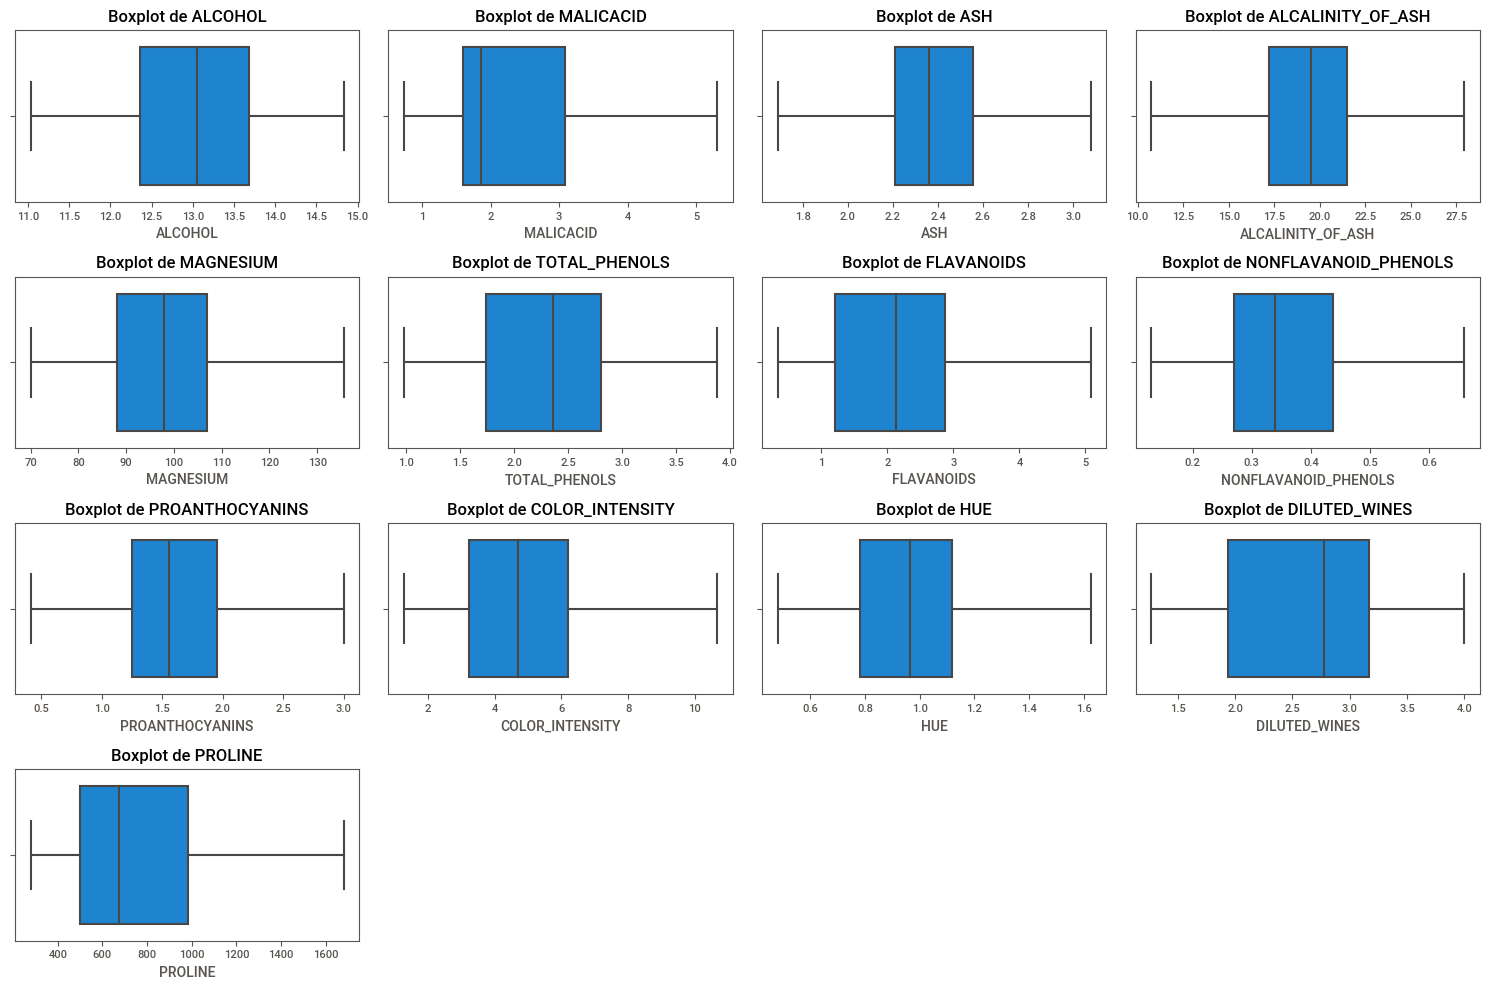

In [0]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(column_names[1:]): 
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df_RIQ1[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()


###  Ahora teniendo en cuenta que requerimos de alguna técnica para balancear las clases se usará SMOTE ya que contamos con pocos datos en cada una de las clases, por lo que realizar undersampling podria quidar datos que posean características únicas e irrecuperable, es por ello que generaremos datos sintéticos que no sean copias identicas a otros que ya poseamos

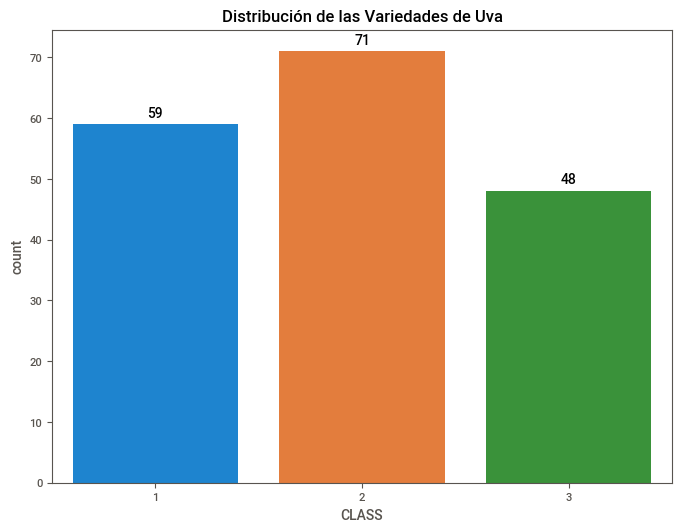

In [0]:
# Gráfico de conteo con etiquetas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CLASS', data=df)
plt.title('Distribución de las Variedades de Uva')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

In [0]:
# Separar las características (X) y la variable objetivo (y)
X = df_RIQ1.drop("CLASS", axis=1)
y = df_RIQ1["CLASS"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # usaremos 80 vs 20% dada la cantidad de datos
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [0]:
print("Distribución de clases antes de SMOTE:")
print(y_train.value_counts())


Distribución de clases antes de SMOTE:
2    57
1    47
3    38
Name: CLASS, dtype: int64


In [0]:
print("\nDistribución de clases después de SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Distribución de clases después de SMOTE:
1    57
3    57
2    57
Name: CLASS, dtype: int64


In [0]:
# Escalado de los datos para la regresión 
scaler = StandardScaler()

# Aplicar escalado solo al conjunto de características (X)
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [0]:
mlflow.set_experiment("/Users/demolinar25@gmail.com/wine_classification_project")

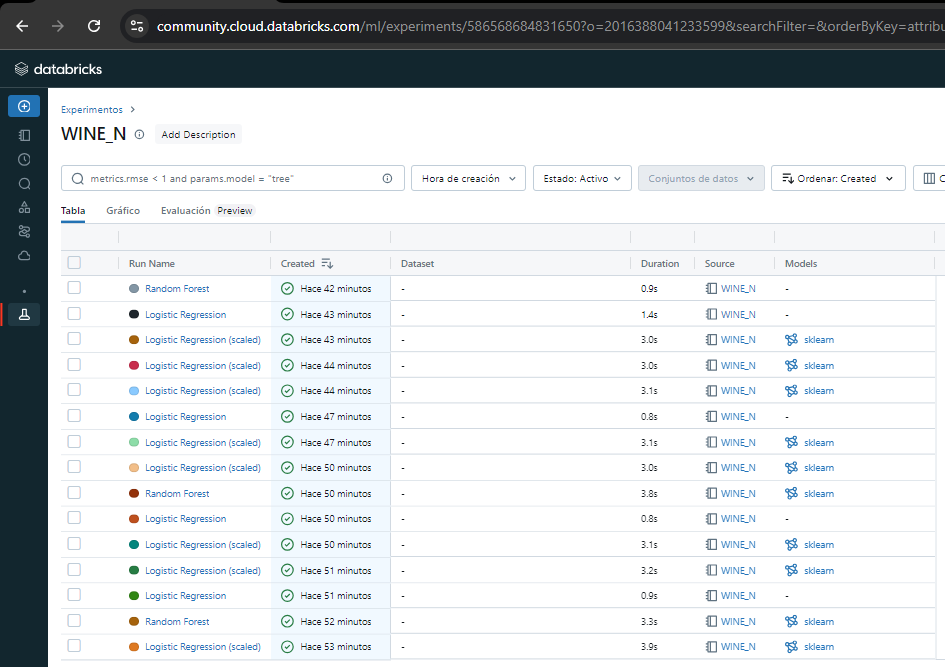

In [0]:

def registrar_matriz_confusion_en_mlflow(y_test, y_pred, clases, run_name="Modelo"):
    """
    Registra los valores de la matriz de confusión en MLflow y guarda la visualización como artefacto.
    """
    # matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_positive = conf_matrix[0][0]
    false_positive = conf_matrix[0][1]
    false_negative = conf_matrix[1][0]
    true_negative = conf_matrix[1][1]
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("false_negative", false_negative)
        mlflow.log_metric("true_negative", true_negative)

        # Visualizar y guardar la matriz de confusión como artefacto
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
        plt.title(f'Matriz de Confusión - {run_name}')
        plt.xlabel("Predicciones")
        plt.ylabel("Valores Reales")
        # Guardar la imagen
        confusion_matrix_path = f"confusion_matrix_{run_name}.png"
        plt.savefig(confusion_matrix_path)
        plt.close()
        # Registrar la imagen como artefacto en MLflow
        mlflow.log_artifact(confusion_matrix_path, "confusion_matrix")
        os.remove(confusion_matrix_path)

        print(f"Matriz de confusión para {run_name} registrada en MLflow.")
        
def graficar_matriz_confusion(y_true, y_pred, clases, titulo="Matriz de Confusión"):
    """
    Función para graficar la matriz de confusión.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
    plt.title(titulo)
    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.show()

# Clases en tu conjunto de datos
clases = ['Clase 1', 'Clase 2', 'Clase 3']

# Regresión Logística

In [0]:


with mlflow.start_run(run_name="Logistic Regression (scaled)"):
    lr = LogisticRegression(max_iter=4, solver='lbfgs', random_state=42)
    lr.fit(X_train_balanced_scaled, y_train_balanced)
    
    y_pred = lr.predict(X_test_scaled)
    y_proba = lr.predict_proba(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

    mlflow.log_param("Modelo", "Regresión Logística (Escalado)")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", roc_auc)
    
    mlflow.sklearn.log_model(lr, "modelo")
    
    print("Accuracy:", acc)
    print("ROC AUC:", roc_auc)

/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/12/06 22:44:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-5032e-64aae-1bf29-5/tmp6fktbinr/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/06 22:44:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` 

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 1.0
ROC AUC: 1.0
🏃 View run Logistic Regression (scaled) at: https://community.cloud.databricks.com/ml/experiments/586568684831650/runs/07f40d8a717348b3baed07e4eaf3625e
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/586568684831650


Matriz de confusión para Logistic Regression registrada en MLflow.
🏃 View run Logistic Regression at: https://community.cloud.databricks.com/ml/experiments/586568684831650/runs/eb5a02dd576b472fa8a2e7a2e3e0c1ec
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/586568684831650


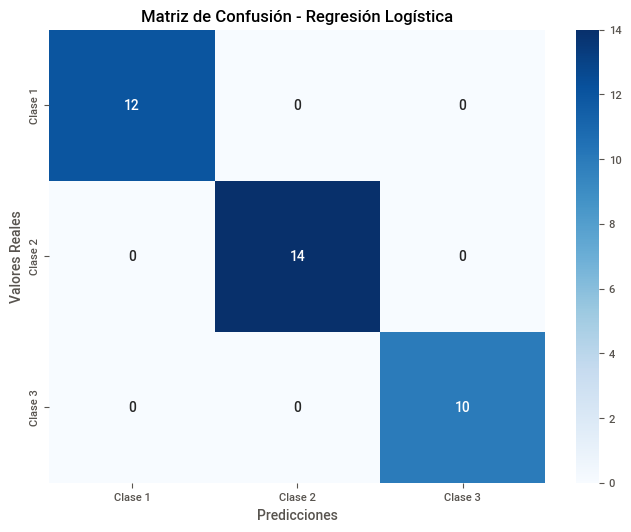

In [0]:
y_pred_lr = lr.predict(X_test_scaled)
registrar_matriz_confusion_en_mlflow(y_test, y_pred_lr, clases, run_name="Logistic Regression")
graficar_matriz_confusion(y_test, y_pred_lr, clases, titulo="Matriz de Confusión - Regresión Logística")

# Random Forest

In [0]:
with mlflow.start_run(run_name="Random Forest"):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_balanced_scaled, y_train_balanced)
    y_pred_rf = rf.predict(X_test_scaled)
    y_proba_rf = rf.predict_proba(X_test_scaled)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
    mlflow.log_param("Modelo", "Random Forest")
    mlflow.log_metric("Accuracy", acc_rf)
    mlflow.log_metric("ROC_AUC", roc_auc_rf)
    mlflow.sklearn.log_model(rf, "modelo")
    print("Random Forest - Accuracy:", acc_rf)
    print("Random Forest - ROC AUC:", roc_auc_rf)

2024/12/06 22:37:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-5032e-64aae-1bf29-5/tmpbhcfdwxn/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/06 22:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Random Forest - Accuracy: 1.0
Random Forest - ROC AUC: 1.0
🏃 View run Random Forest at: https://community.cloud.databricks.com/ml/experiments/586568684831650/runs/a3612b5f3f8b443a94ef804ba3c6b251
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/586568684831650


## IMPORTANCIA VARIABLES RF

          Característica  Importancia
6             FLAVANOIDS     0.188407
9        COLOR_INTENSITY     0.182472
12               PROLINE     0.140214
11         DILUTED_WINES     0.104866
10                   HUE     0.095019
0                ALCOHOL     0.092250
5          TOTAL_PHENOLS     0.041064
4              MAGNESIUM     0.039096
1              MALICACID     0.037781
8        PROANTHOCYANINS     0.027935
3      ALCALINITY_OF_ASH     0.025970
2                    ASH     0.017111
7   NONFLAVANOID_PHENOLS     0.007815


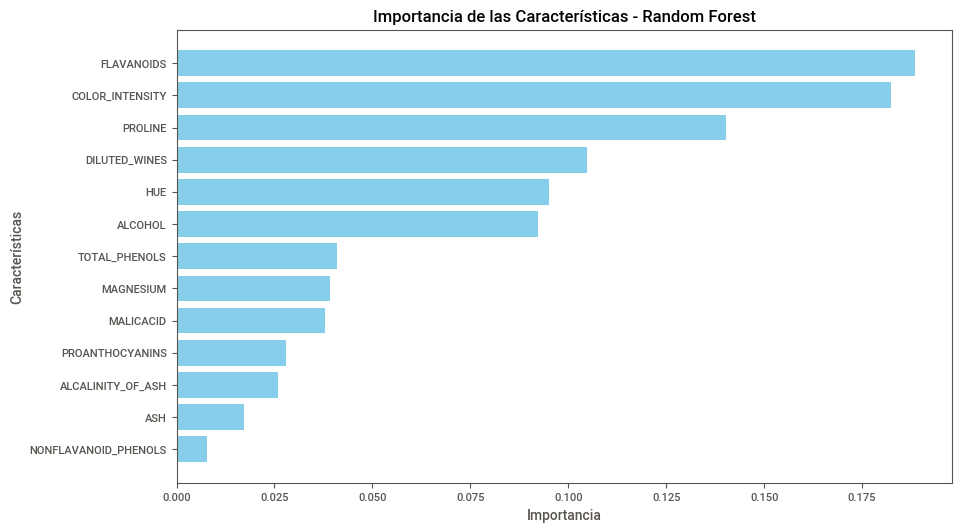

In [0]:
importances = rf.feature_importances_
features = X.columns

# Crear un DataFrame para organizar la importancia
importancia_df = pd.DataFrame({
    'Característica': features,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Mostrar las importancias
print(importancia_df)

# Graficar la importancia de las variables
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importancia_df['Característica'], importancia_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características - Random Forest')
plt.gca().invert_yaxis()
plt.show()

|--- DILUTED_WINES <= -0.39
|   |--- ALCOHOL <= -0.43
|   |   |--- MALICACID <= -0.24
|   |   |   |--- MALICACID <= -1.01
|   |   |   |   |--- FLAVANOIDS <= -1.34
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- FLAVANOIDS >  -1.34
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- MALICACID >  -1.01
|   |   |   |   |--- class: 1.0
|   |   |--- MALICACID >  -0.24
|   |   |   |--- class: 2.0
|   |--- ALCOHOL >  -0.43
|   |   |--- class: 2.0
|--- DILUTED_WINES >  -0.39
|   |--- COLOR_INTENSITY <= -0.79
|   |   |--- class: 1.0
|   |--- COLOR_INTENSITY >  -0.79
|   |   |--- MAGNESIUM <= -0.90
|   |   |   |--- class: 1.0
|   |   |--- MAGNESIUM >  -0.90
|   |   |   |--- DILUTED_WINES <= -0.04
|   |   |   |   |--- class: 2.0
|   |   |   |--- DILUTED_WINES >  -0.04
|   |   |   |   |--- class: 0.0



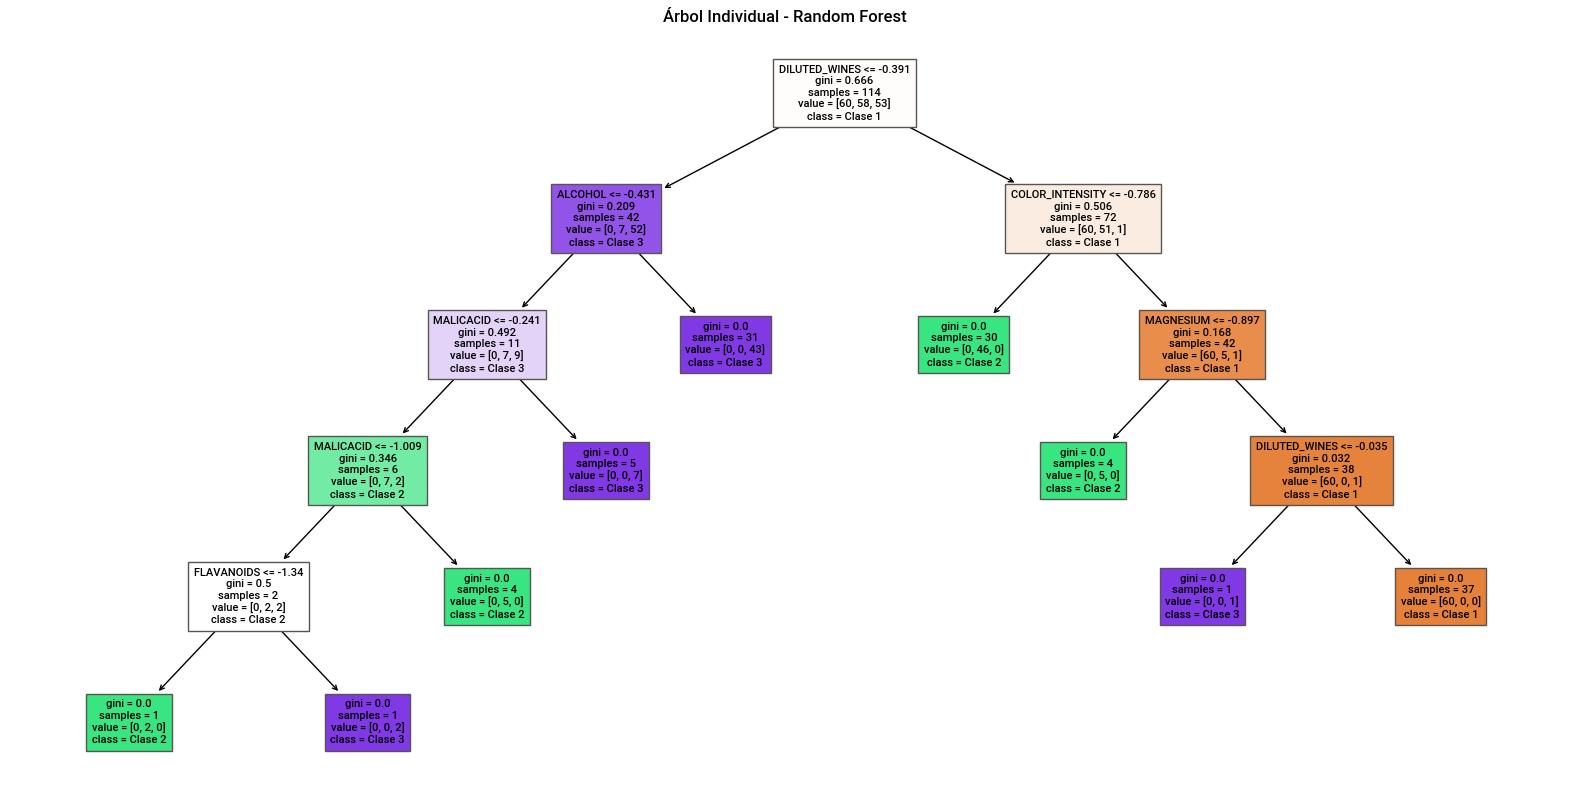

In [0]:
# Extraer un árbol del bosque
arbol = rf.estimators_[0]  # Primer árbol del bosque

# Mostrar las reglas del árbol en texto
print(export_text(arbol, feature_names=list(X.columns)))

# Visualizar el árbol gráficamente
plt.figure(figsize=(20, 10))
plot_tree(arbol, feature_names=X.columns, class_names=clases, filled=True, fontsize=8)
plt.title("Árbol Individual - Random Forest")
plt.show()

Matriz de confusión para Random Forest registrada en MLflow.
🏃 View run Random Forest at: https://community.cloud.databricks.com/ml/experiments/586568684831650/runs/c0946e2338964421a3b313f24241f5e5
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/586568684831650


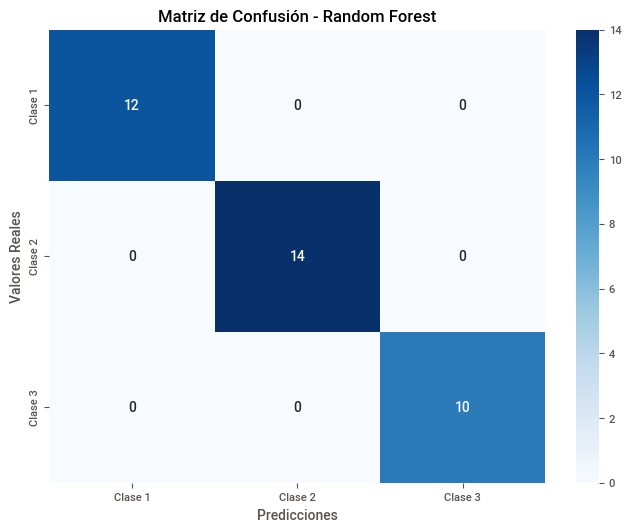

In [0]:
y_pred_rf = rf.predict(X_test_scaled)
registrar_matriz_confusion_en_mlflow(y_test, y_pred_rf, clases, run_name="Random Forest")
graficar_matriz_confusion(y_test, y_pred_rf, clases, titulo="Matriz de Confusión - Random Forest")

# INFERENCIA

In [0]:
inferencias = [
    [13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
    [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]
]

inferencias_df = pd.DataFrame(inferencias, columns=X.columns)
inferencias_scaled = scaler.transform(inferencias_df) #debemos escalar

In [0]:

model_uri = "runs:/a3612b5f3f8b443a94ef804ba3c6b251/modelo"
rf_model = mlflow.sklearn.load_model(model_uri)

In [0]:
# Predecir la clase de las nuevas muestras
predicciones = rf_model.predict(inferencias_scaled)
for i, pred in enumerate(predicciones):
    print(f"Muestra {i+1}: Predicción -> Clase {pred}")

Muestra 1: Predicción -> Clase 1
Muestra 2: Predicción -> Clase 2


In [0]:
# Obtener las probabilidades de predicción
probabilidades = rf_model.predict_proba(inferencias_scaled)
# Mostrar las probabilidades
for i, probs in enumerate(probabilidades):
    print(f"Muestra {i+1}: Probabilidades -> {dict(zip(clases, probs))}")

Muestra 1: Probabilidades -> {'Clase 1': 0.97, 'Clase 2': 0.03, 'Clase 3': 0.0}
Muestra 2: Probabilidades -> {'Clase 1': 0.0, 'Clase 2': 0.93, 'Clase 3': 0.07}
